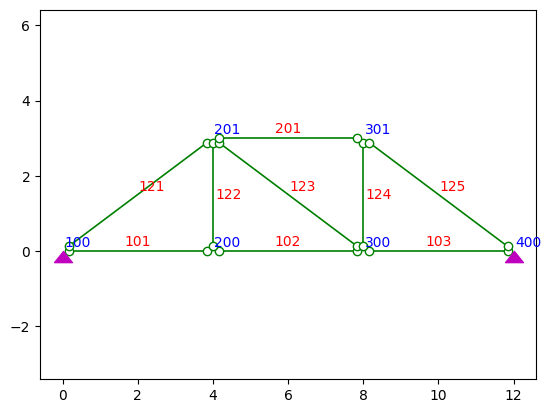

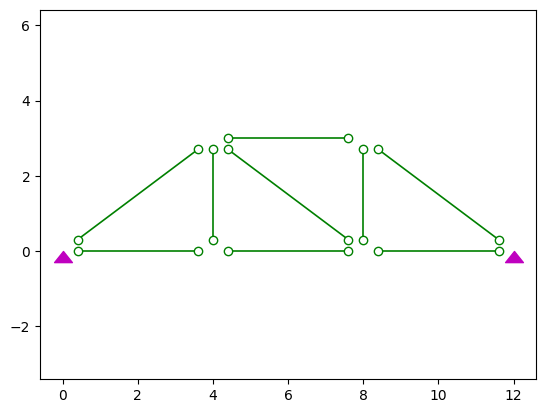

Análisis Gravitacional Exitoso


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

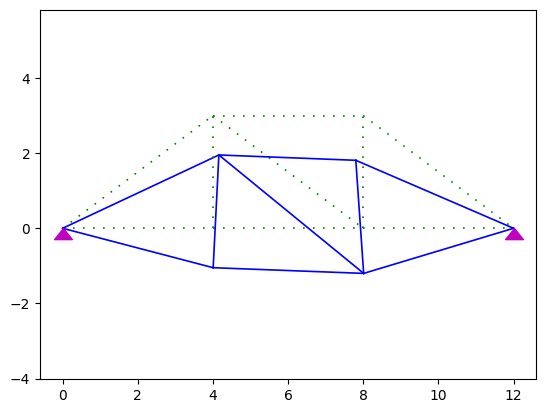

In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import Tools.Resultados as rs             # type: ignore

ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 2)

# Coordenadas de los Nodos -----------------------------------------------------------------------
L = 4
H = 3
Nodos = [100, 200, 201, 300, 301, 400]
CoordXY = np.array([[0., 0.], [L, 0], [L, H], [2*L, 0], [2*L, H], [3*L, 0]])

for i in range(len(Nodos)):     # Recorremos los nodos y vamos acumulando la longitud
    iNode, jNode = CoordXY[i][0], CoordXY[i][1]
    ops.node(Nodos[i], iNode, jNode)

# Condiciones de Apoyo ---------------------------------------------------------------------------
ops.fix(Nodos[0], 1, 1)
ops.fix(Nodos[len(Nodos)-1], 1, 1)

# Elementos --------------------------------------------------------------------------------------
Area = 0.005
E_Mod = 2 * 10 ** 8

ops.uniaxialMaterial("Elastic", 1, E_Mod)

Conect_Ele = np.array([[0, 1], [0, 2], [1, 2], [1, 3], [2, 3], [2,4], [3,4], [3,5], [4, 5]])
ElemTag = [101, 121, 122, 102, 123, 201, 124, 103, 125]
for i in range(len(ElemTag)):
    tag, iNode, jNode = ElemTag[i], Nodos[Conect_Ele[i][0]], Nodos[Conect_Ele[i][1]]
    ops.element("Truss", tag, iNode, jNode, Area, 1)
opsv.plot_model()

P201, P301, H201 = 20, 20, 4

ops.timeSeries('Constant',1)
ops.pattern('Plain',1 ,1)
ops.load(Nodos[2], H201, -P201)
ops.load(Nodos[4], 0., -P301)

# Definir parámetros de ejemplo
nep = 2                             # Número de puntos por elemento
sfac = 1.0                          # Factor de escala
fig_wi_he = (8, 6)                  # Ancho y alto de la figura
fig_lbrt = (0.1, 0.1, 0.9, 0.9)     # Márgenes
fmt_model_loads = {'color': 'b', 'linewidth': 2}    # Formato de cargas
node_supports = True                                # Diccionario con información de apoyos (según el modelo)
truss_node_offset = 0.1                             # Desplazamiento de nodos en elementos tipo truss

fig, ax = plt.subplots()                            # Crear figura y ejes
opsv.plot_loads_2d(nep, sfac, fig_wi_he, fig_lbrt, fmt_model_loads, node_supports, truss_node_offset, ax)
plt.show()

rs.analisis_gravitacional()
opsv.plot_defo()

rs.reacciones_Truss_OPS(Nodos)
rs.desplazamientos_Truss_OPS(Nodos)
rs.fuerzaslocales_Truss_OPS(ElemTag)
rs.deformaciones_Truss_OPS(ElemTag)

In [4]:
# Inicializar listas para almacenar resultados
longitudes = []
angulos_deg = []

for i, (n1, n2) in enumerate(Conect_Ele):
    x1, y1 = CoordXY[n1]
    x2, y2 = CoordXY[n2]
    
    dx = x2 - x1
    dy = y2 - y1
    
    longitud = np.sqrt(dx**2 + dy**2)
    angulo_rad = np.arctan2(dy, dx)         # Ángulo en radianes
    angulo_deg = np.degrees(angulo_rad)     # Ángulo en grados
    
    longitudes.append(longitud)
    angulos_deg.append(angulo_deg)
    #print(f"Elemento {ElemTag[i]}: Longitud = {longitud:.2f}, Ángulo = {angulo_deg:.2f}°")

def rigidez(E, A, L):
    return E * A * np.array([[1, 0, -1, 0], [0, 0,  0, 0], [-1, 0, 1, 0], [0, 0,  0, 0]]) / L

ki = [rigidez(E_Mod, Area, L) for L in longitudes]

eta = np.cos(np.radians(angulos_deg))           # Ángulos en grados → coseno y seno
mu = np.sin(np.radians(angulos_deg))

# Lista para almacenar las matrices de transformación
matrices_Ti, matrices_Ki_global = [], []

for i in range(len(angulos_deg)):
    e, m = eta[i], mu[i]
    
    T = np.array([[ e,  m, 0, 0], [-m,  e, 0, 0], [ 0,  0, e, m], [ 0,  0,-m, e]])
    
    matrices_Ti.append(T)
    
    K_global = T.T @ ki[i] @ T         # Transformar matriz local a global
    matrices_Ki_global.append(K_global)
    #print(f"K_global del elemento {ElemTag[i]}:\n{K_global}\n")

g_i = [[2*i, 2*i + 1] for i in range(len(Nodos))]

gdl_i = []
for i in range(len(Conect_Ele)):
    xgdl, ygdl = Conect_Ele[i][0], Conect_Ele[i][1]
    
    gdl = [g_i[xgdl][0], g_i[xgdl][1], g_i[ygdl][0], g_i[ygdl][1]]    
    gdl_i.append(gdl)

ndof = 12
K = np.zeros((ndof, ndof))

for i in range(len(matrices_Ki_global)):        # Ensamblaje de la matriz global
    g = gdl_i[i]
    K_e = matrices_Ki_global[i]
    
    for ii in range(4):
        for jj in range(4):
            K[g[ii], g[jj]] += K_e[ii, jj]

ai, bi = [0, 5], [1, 2, 3, 4]

a, b = [], []
for i in range(len(ai)):
    xgdl, ygdl = g_i[ai[i]][0], g_i[ai[i]][1]
    a.append(xgdl); a.append(ygdl)

for i in range(len(bi)):
    xgdl, ygdl = g_i[bi[i]][0], g_i[bi[i]][1]
    b.append(xgdl); b.append(ygdl)

K_aa = K[np.ix_(a, a)]
K_ab = K[np.ix_(a, b)]
K_ba = K[np.ix_(b, a)]
K_bb = K[np.ix_(b, b)]

# Vector de cargas (transpuesto para convertir a columna)
P = np.array([0, 0, 0, 0, 4, -20, 0, 0, 0, -20, 0, 0]).reshape(-1, 1)

P_b = P[b]                          # Vector de cargas en los DOFs libres
D_b = np.linalg.solve(K_bb, P_b)    # Resolviendo desplazamientos en DOFs libres
P_a = K_ab @ D_b                    # Calculando reacciones
D = np.zeros((12, 1))               # Vector total de desplazamientos
D[b] = D_b

rs.desplazamientosNodos_Truss_Matlab(D)

g_1 = gdl_i[0]
d_1 = D[g_1]                            # Desplazamientos del elemento 1

k1 = ki[0]
p_1 = k1 @ d_1                          # Fuerzas del elemento 1

Q_ab = K_ab @ D_b                       # Calcular reacciones (Q)
Q = np.zeros_like(P)                    # Vector Q con reacciones en la posición correcta
Q[a] = Q_ab

def calcular_esfuerzos(E_Mod, D, gdl_i, longitudes, angulos_deg):
    sigma = []

    for i in range(len(gdl_i)):
        beta = np.deg2rad(angulos_deg[i])               # convertir a radianes
        eta, mu = np.cos(beta), np.sin(beta)
        D_i = D[gdl_i[i]]                               # Extraer desplazamientos de los gdl correspondientes
        B = np.array([-eta, -mu, eta, mu])
        sigma_i = (E_Mod / longitudes[i]) * B @ D_i
        sigma.append(sigma_i)

    return np.array(sigma)

sigma = calcular_esfuerzos(E_Mod, D, gdl_i, longitudes, angulos_deg)
print(sigma)

<IPython.core.display.Math object>

[[   88.88888889]
 [-6333.33333333]
 [    0.        ]
 [   88.88888889]
 [ -333.33333333]
 [-5600.        ]
 [  200.        ]
 [ -177.77777778]
 [-7000.        ]]
